# Project 3 - Reddit NLP
## 05-Additional Models

In this final section, I will begin by assessing several models with base parameters. I will then select the two best models for grid searching. 

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import balanced_accuracy_score, f1_score

from sklearn.pipeline import make_pipeline
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings("ignore")

In [45]:
df = pd.read_csv('./data/legal_nsq_clean.csv')

In [46]:
df.head(2)

,created_utc,subreddit,author,media_only,permalink,clean_text,clean_title,alltext_clean,alltext_word_count,title_word_count,selftext_word_count
0,1601524380,legaladvice,Gtormund51,False,/r/legaladvice/comments/j31aqq/my_ex_gf_refuse...,About a week ago I ended a moderately long rel...,My ex gf refuses to reclaim her items from my ...,My ex gf refuses to reclaim her items from my ...,136,23,113
1,1601524283,legaladvice,hustlegoat,False,/r/legaladvice/comments/j319w1/a_car_is_advert...,So I'm looking for a new car and I stumbled up...,A car is advertised for 18 000 lower than MSRP...,A car is advertised for 18 000 lower than MSRP...,105,21,85


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55713 entries, 0 to 55712
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   created_utc          55713 non-null  int64 
 1   subreddit            55713 non-null  object
 2   author               55713 non-null  object
 3   media_only           55713 non-null  bool  
 4   permalink            55713 non-null  object
 5   clean_text           55713 non-null  object
 6   clean_title          55713 non-null  object
 7   alltext_clean        55713 non-null  object
 8   alltext_word_count   55713 non-null  int64 
 9   title_word_count     55713 non-null  int64 
 10  selftext_word_count  55713 non-null  int64 
dtypes: bool(1), int64(4), object(6)
memory usage: 4.3+ MB


In [48]:
df['subreddit'], names = pd.factorize(df['subreddit'])

### Set up X and y and train/test/split

In [49]:
X = df['alltext_clean']
y = df['subreddit']

In [50]:
X.head()

0    My ex gf refuses to reclaim her items from my ...
1    A car is advertised for 18 000 lower than MSRP...
2    Can my boss make me 16 year old work 28.5 hour...
3    I m leaving him and taking the dog. What can I...
4    NONPROFIT T SHIRT LOGO infringement???Can I be...
Name: alltext_clean, dtype: object

In [51]:
y.head

<bound method NDFrame.head of 0        0
1        0
2        0
3        0
4        0
        ..
55708    1
55709    1
55710    1
55711    1
55712    1
Name: subreddit, Length: 55713, dtype: int64>

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22)

In [53]:
X_train.shape

(41784,)

In [54]:
y_train.shape

(41784,)

### Model Exploration

Here, I will instantiate 7 different models. I then create a function that will put each estimator through a pipeline, along with CountVectorizer, and will provide testing and training scores. Based off of these scores, I will choose the 2 estimators with the highest scores for gridsearching and a more in-depth analysis.

In [55]:
lr = LogisticRegression(max_iter=10_000)
knn = KNeighborsClassifier()
dtc = DecisionTreeClassifier()
bag = BaggingClassifier()
rfc = RandomForestClassifier()
ada = AdaBoostClassifier()
svc = SVC()

In [56]:
def multi_class(estimator):
    pipe = make_pipeline(CountVectorizer(), estimator)
    pipe.fit(X_train, y_train)
    return f'Train score, {estimator}: {pipe.score(X_train, y_train)}   \nTest score, {estimator}: {pipe.score(X_test, y_test)}'

In [57]:
estimators = [lr, knn, dtc, bag, rfc, ada, svc]

for est in estimators:
    print(multi_class(est))

Train score, LogisticRegression(max_iter=10000): 0.9921501053034655   
Test score, LogisticRegression(max_iter=10000): 0.9494579653959365
Train score, KNeighborsClassifier(): 0.8655944859276278   
Test score, KNeighborsClassifier(): 0.8262617560485318
Train score, DecisionTreeClassifier(): 0.9999521347884358   
Test score, DecisionTreeClassifier(): 0.8677579151410726
Train score, BaggingClassifier(): 0.9926048248133257   
Test score, BaggingClassifier(): 0.9039414171871635
Train score, RandomForestClassifier(): 0.9999521347884358   
Test score, RandomForestClassifier(): 0.9040850025127432
Train score, AdaBoostClassifier(): 0.9052029484970323   
Test score, AdaBoostClassifier(): 0.9071720870127074
Train score, SVC(): 0.9551024315527474   
Test score, SVC(): 0.9414889798262618


**Assessment:** Logistic regression has the highest training and testing scores. Most of the tree models show evidence of overfitting, but based on the Random Forests high scores, I will attempt to use hyperparameters to further tune this model, in hopes of decreasing the overfitting by adding in some bias.

### Logistic Regression with Count Vectorizer

First, I will gridsearch over a logistic regression model. The parameters shown below have been narrowed down after attempting several different gridsearches.

**Lemmatizing:** I will create a function for lemmatizing that I can use as a preprocessor in the grid search. I will also grid search over two different stop words in accordance with the preprocessors.

In [58]:
def split_lem(text):
    text = text.lower()
    lem = WordNetLemmatizer()
    return ' '.join([lem.lemmatize(word) for word in text.split()])

In [59]:
pipe = make_pipeline(
    CountVectorizer(stop_words=stopwords.words('english'), min_df=5),
    LogisticRegression(max_iter=10_000)
)

params = {
    'countvectorizer__max_features': [20_000, 30_000],
    'countvectorizer__ngram_range': [(1,2)],
    'countvectorizer__preprocessor': [None, split_lem]
}

grid = GridSearchCV(pipe, params, n_jobs=-1)

In [60]:
grid.fit(X_train, y_train)
print("Train score: ", grid.score(X_train, y_train))
print("Test score: ", grid.score(X_test, y_test))

Train score:  0.9938253877082137
Test score:  0.9441453083494867


In [16]:
grid.best_params_

{'countvectorizer__max_features': 30000,
 'countvectorizer__ngram_range': (1, 2),
 'countvectorizer__preprocessor': None}

**Model Evaluation:** Overall, additional parameters did not have a strong impact on the overall test score. I continue to find that the more features incorporated, the better the model performs.

### Additional Classification Metrics

In [38]:
y_preds = grid.predict(X_test)

In [39]:
f1_score(y_test, y_preds)

0.9335729690869877

In [40]:
balanced_accuracy_score(y_test, y_preds)

0.9342831227091604

**Metrics Analysis:** Similar to the Naive Bayes model, the f1 score is close to 1. This indicates that the model is well balanced, and does not favor either precision or or recall. The balanced accuracy score is also close to 1, however it is slightly lower than our overall accuracy score. This indicates that there is a slight preference for the 0 class, Legal Advice. 

### Coefficients

One of the things that I appreciate the most about a logistic regression model is the interpretability of the coefficients.

In [71]:
word_coefs = grid.best_estimator_.named_steps['logisticregression'].coef_[0]
words = grid.best_estimator_.named_steps['countvectorizer'].get_feature_names()
word_coef_df = pd.DataFrame({'Coefficients': word_coefs, 'Word': words})
word_coef_df.sort_values(by='Coefficients',ascending=False)

,Coefficients,Word
211,1.627823,2001
14217,1.483788,legal guardian
28661,1.370406,weird
3245,1.283066,blue
15373,1.256304,majority
...,...,...
3639,-2.022414,ca
2378,-2.113761,attorney
14281,-2.145766,legally
14189,-2.426101,legal


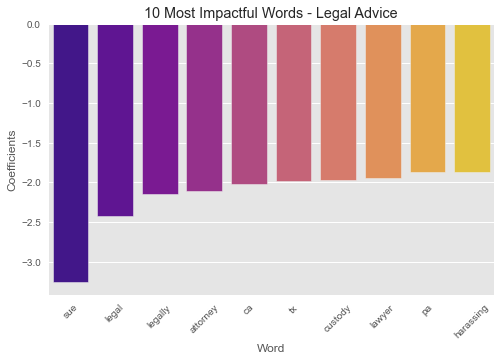

In [72]:
plt.style.use('ggplot')
plt.subplots(figsize=(8, 5))
sns.barplot('Word', 'Coefficients', data=word_coef_df.sort_values(by='Coefficients')[:10], palette='plasma')
plt.xticks(rotation=45)
plt.title('10 Most Impactful Words - Legal Advice');

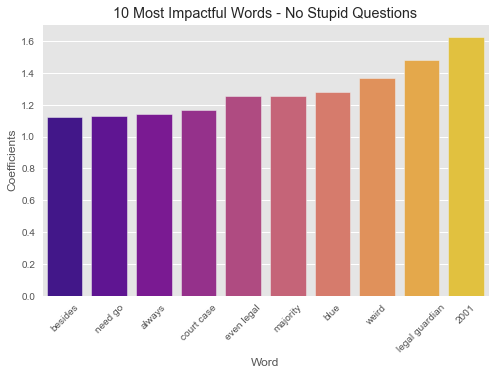

In [73]:
plt.subplots(figsize=(8, 5))
sns.barplot('Word', 'Coefficients', data=word_coef_df.sort_values(by='Coefficients')[-10:], palette='plasma')
plt.xticks(rotation=45)
plt.title('10 Most Impactful Words - No Stupid Questions');

**Interpretations:**
Here, the coefficients represent the log odds - so negative coefficients increase the log odds of the submission being from Legal Advice, and positive coefficients increase the log odds of the submission coming from No Stupid Questions. The Top 10 words in Legal advice all make sense as legal advice indicators. 
No Stupid Questions are a bit more random. Legal guardian, for example, would be logically assumed to indicate legal advice. It is also interesting that "legal" has a positive coefficient, but as a bigram, "legal guardian" becomes an indicator of No Stupid Questions. Similarly, "even legal" and "court case."  


### Logistic Regression Pipeline

Recreating the gridsearch, using the best parameters.

In [69]:
lr_pipe = make_pipeline(
    CountVectorizer(stop_words = stopwords.words('english'), min_df=5, ngram_range=(1,2), max_features=30000), 
    LogisticRegression(max_iter=10000))

In [70]:
lr_pipe.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=30000, min_df=5,
                                 ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('logisticregression', LogisticRegression(max_iter=10000))])

### Logistic Regression Visualizations

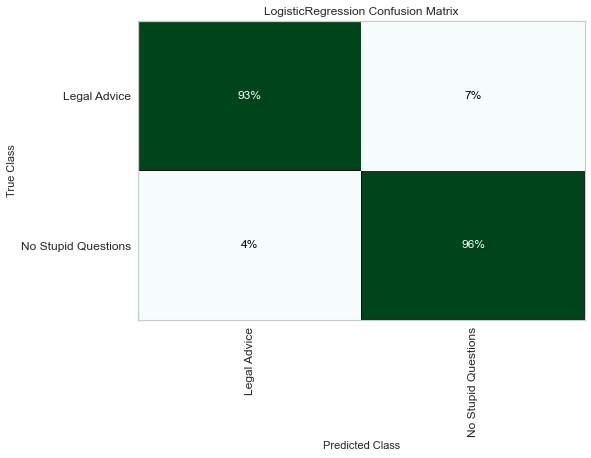

In [65]:
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.style.palettes import PALETTES, SEQUENCES, color_palette
cm = ConfusionMatrix(
    lr_pipe, classes=['Legal Advice', 'No Stupid Questions'],
    percent=True,
    cmap='BuGn'
)
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show();

**Confusion Matrix:** Here we can see that the model is slightly less balanced than the Naive Bayes model. This shows that the model is slighly better at accurately predicting No Stupid Questions than Legal Advice.

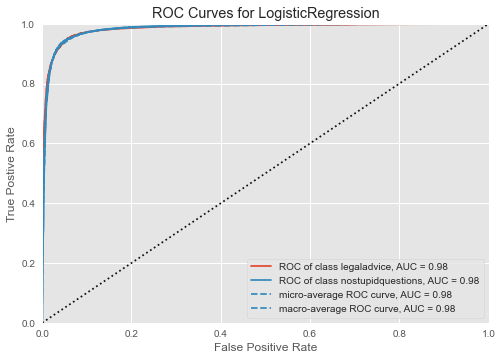

In [75]:
from yellowbrick import ROCAUC
rocauc_viz = ROCAUC(lr_pipe, classes=['legaladvice', 'nostupidquestions'])
rocauc_viz.fit(X_train, y_train)
rocauc_viz.score(X_test, y_test)
rocauc_viz.show();

**ROC Curve:** This is a visual representation of our predictive ability, and the tradeoff between sensitivity and specificity. The curve is very close to the upper left hand corner, indicating strong predictability. The close alignment of the curves for each class shows a similar tradeoff for each class.

In [76]:
pipe2 = make_pipeline(
    CountVectorizer(stop_words='english'),
    RandomForestClassifier()
)

params2 = {
    'countvectorizer__max_features': [30_000],
    'countvectorizer__ngram_range': [(1,2)],
    'randomforestclassifier__n_estimators': [500, 1000, 2000],
    'randomforestclassifier__max_depth': [25, 50, 100],
}

grid2 = GridSearchCV(pipe2, params2, n_jobs=-1)

In [77]:
grid2.fit(X_train, y_train)


GridSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(stop_words='english')),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'countvectorizer__max_features': [30000],
                         'countvectorizer__ngram_range': [(1, 2)],
                         'randomforestclassifier__max_depth': [25, 50, 100],
                         'randomforestclassifier__n_estimators': [500, 1000,
                                                                  2000]})

In [78]:
print("Train score: ", grid2.score(X_train, y_train))
print("Test score: ", grid2.score(X_test, y_test))

Train score:  0.9867413363967069
Test score:  0.9272022399310791


In [79]:
grid2.best_params_

{'countvectorizer__max_features': 30000,
 'countvectorizer__ngram_range': (1, 2),
 'randomforestclassifier__max_depth': 100,
 'randomforestclassifier__n_estimators': 1000}

**Model evaluation:** Here, we see a slight narrowing our our train and test scores compared to the baseline parameter model. Training accuracy score has gone down about 1%, while testing accuracy score has increased 2%. This means that we have successfully added some bias into the model.

In [80]:
rf_pipe = make_pipeline(
    CountVectorizer(stop_words = stopwords.words('english'), min_df=5, ngram_range=(1,2), max_features=30000), 
    RandomForestClassifier(max_depth = 100, n_estimators = 2000))

In [81]:
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=30000, min_df=5,
                                 ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=100, n_estimators=2000))])

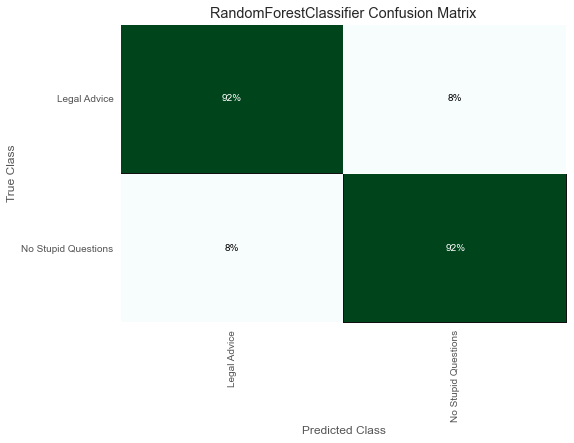

In [82]:
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.style.palettes import PALETTES, SEQUENCES, color_palette
cm = ConfusionMatrix(
    rf_pipe, classes=['Legal Advice', 'No Stupid Questions'],
    percent=True,
    cmap='BuGn'
)
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show();

**Confusion Matrix:** Here, similar to the Naive Bayes model, we see balance between the two classes.

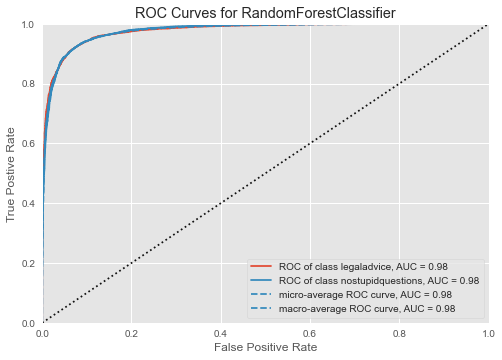

In [83]:
from yellowbrick import ROCAUC
rocauc_viz = ROCAUC(rf_pipe, classes=['legaladvice', 'nostupidquestions'])
rocauc_viz.fit(X_train, y_train)
rocauc_viz.score(X_test, y_test)
rocauc_viz.show();

**ROC Curve:** Similar to the Logistic Regression model, the curve is very close to the upper left hand corner, indicating strong predictability. The close alignment of the curves for each class shows a similar tradeoff for each class.